<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Необходимо построить модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Начнем работу с импорта необходимых для работы библиотек

In [1]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

Откроем датасет, выведем первые несколько строк датасета, а также выведем информацию о нем

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
display(data.head(10))
data.info()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Как мы видим пропуски в обоих столбцах отсутствуют - приступим к обработке столбца с текстом

Для начала очистим текст от лишних символов с помощью регулярных выражений. Напишем для этого соответствующую функцию

In [3]:
def clear_text(text):
    t = re.sub(r'[^a-zA-Z]', ' ', text)
    t1 = t.split() 
    t2 = ' '.join(t1)
    return t2.lower()

Посмотрим на результат выполнения нашей функции на рандомной строке

In [4]:
data['text'] = data['text'].apply(clear_text)
print(data['text'].loc[5])

congratulations from me as well use the tools well talk


Как мы видим все лишние символы были убраны. Далее нам необходимо провести токенизацию и лемматизацию исходного текста. Напишем для этого соответствующую функцию. Поскольку комментарии у нас на английском будем использовать лемматизатор Wordnet

In [5]:
lem = WordNetLemmatizer()

def tok_lem(text):
    tok_text = nltk.word_tokenize(text)
    lem_text = ' '.join([lem.lemmatize(i) for i in tok_text])
    return lem_text

Посмотрим на результат выполнения нашей функции на той же строке

In [6]:
data['text'] = data['text'].apply(tok_lem)
print(data['text'].loc[5])

congratulation from me a well use the tool well talk


Как мы видим лемматизация прошла успешно - двигаемся дальше

Посмотрим на распределение характера комментариев в столбце 'toxic'

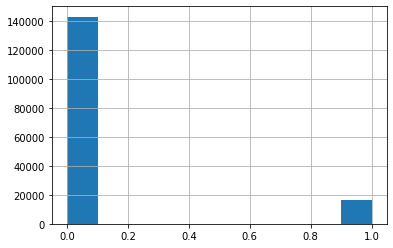

0    143106
1     16186
Name: toxic, dtype: int64


In [7]:
data['toxic'].hist()
plt.show()
print(data['toxic'].value_counts())

Как мы видим баланс классов далек от 1:1, поэтому нам будет необходимо это учитывать в дальнейшем при работе с моделями

Разобьем данные на выборки: выделим 20% данных для тестовой выборки, остальные 80% — для обучающей и валидационной

In [8]:
data_train_valid, data_test = train_test_split(data, test_size=0.2, random_state=12345)

Далее из обучающей и валидационной выборок выделим каждую из них по отдельности. На валидационную выделим 25%, а на обучающую 75%

In [9]:
data_train, data_valid = train_test_split(data_train_valid, test_size=0.25, random_state=12345)

Целевым признаком в нашем датасете является столбец "toxic" - именно в нем содержится информация о характере комментария и его нам необходимо будет предсказывать. Столбец 'text' с непосредственным текстом комментариев будет признаком. Создадим переменные для признаков и целевого признака для каждой выборки

In [10]:
features_train = data_train['text']
target_train = data_train['toxic']
features_valid = data_valid['text']
target_valid = data_valid['toxic']
features_test = data_test['text']
target_test = data_test['toxic']

Получим TF-IDF для нашего столбца с комментариями, но перед этим добавим английские стоп-слова

In [11]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
count_tf_idf = TfidfVectorizer(stop_words=list(stopwords))

features_train = count_tf_idf.fit_transform(features_train)
features_valid = count_tf_idf.transform(features_valid)
features_test = count_tf_idf.transform(features_test)

<b>Вывод: </b> мы проанализировали исходный датасет, оценили баланс классов в нем, построили соответствующий график, обработали текстовые данные, подготовили и провели разделение датасета на выборки.

## Обучение

Применим модель "Логистическая регрессия" и вычислим значение F1-меры

In [13]:
%%time

model = LogisticRegression(class_weight='balanced', random_state=12345, solver = 'liblinear') # учитываем несбалансированность классов
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
print(f1_score(target_valid, predictions))

0.7407103825136612
CPU times: user 5.41 s, sys: 8.04 s, total: 13.4 s
Wall time: 13.5 s


Подберем наилучшие параметры для модели "Логистическая регрессия" и вычислим значение F1-меры

In [14]:
%%time

best_model = None
best_f1 = 0
for i in range(2, 15):
    model = LogisticRegression(class_weight='balanced', random_state=12345, solver = 'liblinear', C=i)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions)
    if f1 > best_f1:
        best_model = model
        best_f1 = f1
print("Параметры наилучшей модели:", best_model)
print("F1 лучшей модели 'Логистическая регрессия':", best_f1)

Параметры наилучшей модели: LogisticRegression(C=5, class_weight='balanced', random_state=12345,
                   solver='liblinear')
F1 лучшей модели 'Логистическая регрессия': 0.7531249999999999
CPU times: user 1min 48s, sys: 3min 1s, total: 4min 50s
Wall time: 4min 50s


Зафиксируем гипермараметры наилучшей модели "Логистическая регрессия" и попробуем другие модели\
<font color='blue'>Примечание: время выполненения около 5 мин, F1 лучшей модели 'Логистическая регрессия': 0.753

Применим модель "Дерево решений": подберем наилучшие параметры и вычислим значение F1-меры

In [16]:
%%time

best_model = None
best_f1 = 0
for i in range(2, 15):
    for j in range(2,15):
            model = DecisionTreeClassifier(class_weight='balanced', random_state=12345, max_depth=i, min_samples_leaf=j)
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            f1 = f1_score(target_valid, predictions)
            if f1 > best_f1:
                best_model = model
                best_f1 = f1
print("Параметры наилучшей модели:", best_model)
print("F1 лучшей модели 'Дерево решений':", best_f1)

Параметры наилучшей модели: DecisionTreeClassifier(class_weight='balanced', max_depth=13,
                       min_samples_leaf=5, random_state=12345)
F1 лучшей модели 'Дерево решений': 0.5925637531633249
CPU times: user 9min 53s, sys: 0 ns, total: 9min 53s
Wall time: 9min 54s


Зафиксируем гипермараметры наилучшего "Дерева решений" и попробуем другие модели\
<font color='blue'>Примечание: время выполненения около 10 мин, F1 лучшей модели 'Дерево решений': 0.592

Применим модель "Случайный лес" и вычислим значение F1-меры

In [17]:
%%time

model = RandomForestClassifier(class_weight='balanced', random_state=12345) # учитываем несбалансированность классов
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
print(f1_score(target_valid, predictions))

0.6101626832697329
CPU times: user 7min 39s, sys: 0 ns, total: 7min 39s
Wall time: 7min 40s


<font color='blue'>Примечание: время выполненения около 7,5 мин, F1 модели 'Случайный лес': 0.61

Применим модель "CatBoost" и вычислим значение F1-меры

In [18]:
%%time

model = CatBoostClassifier(iterations=500)
model.fit(features_train, target_train, verbose=50)
predictions = model.predict(features_valid)
print(f1_score(target_valid, predictions))

Learning rate set to 0.136328
0:	learn: 0.5572577	total: 2.51s	remaining: 20m 52s
50:	learn: 0.1786134	total: 1m 36s	remaining: 14m 12s
100:	learn: 0.1562218	total: 3m 8s	remaining: 12m 26s
150:	learn: 0.1435119	total: 4m 39s	remaining: 10m 46s
200:	learn: 0.1341298	total: 6m 12s	remaining: 9m 13s
250:	learn: 0.1272621	total: 7m 42s	remaining: 7m 39s
300:	learn: 0.1220369	total: 9m 18s	remaining: 6m 8s
350:	learn: 0.1177731	total: 10m 52s	remaining: 4m 36s
400:	learn: 0.1138065	total: 12m 28s	remaining: 3m 4s
450:	learn: 0.1104735	total: 14m 4s	remaining: 1m 31s
499:	learn: 0.1071308	total: 15m 40s	remaining: 0us
0.7333091436865024
CPU times: user 16min, sys: 3.49 s, total: 16min 4s
Wall time: 16min 7s


<font color='blue'>Примечание: время выполненения около 16 мин, F1 модели "CatBoost": 0.733

<b>Вывод: </b> Испытав 4 модели, наилучших результатов мы смогли добиться на модели "Логистическая регрессия". Далее идет модель "CatBoost", однако время ее выполнения ощутимо больше чем у модели "Логистическая регрессия". Далее проверим нашу наилучшую модель на тестовой выборке

## Выводы

Проведем проверку нашей модели "Логистическая регрессия" на тестовой выборке

In [20]:
model = LogisticRegression(class_weight='balanced', random_state=12345, solver = 'liblinear', C=5)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print(f1_score(target_test, predictions))

0.7644787644787645


Как мы видим нам удалось достичь требуемого значения F1-меры для модели "Логистическая регрессия" на тестовой выборке.

<b>Вывод: </b> нами был обработан исходный датасет, обработаны текстовые данные, проанализированы признаки, подготовлено и протестировано несколько моделей. Выбрав модель 'Логистическая регрессия', показавшую наилучшее значение F1-меры на валидационной выборке и проверив ее на тестовой выборке нам удалось достичь требуемого значения F1-меры. Таким образом наша модель сможет классифицировать комментарии в интернет-магазине «Викишоп» на позитивные и негативные и в дальнейшем токсичные негативные комментарии будут отправляться на модерацию. 